In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
import time
import tensorflow as tf
import shap
import numpy as np
tf.compat.v1.disable_v2_behavior()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# load data
df = pd.read_csv('UNSW_NB15_balanced_smote.csv')
df.drop(['attack_cat'], axis=1, inplace=True)

In [3]:
X = df.drop('label', axis=1)
Y = df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [4]:
# load binary model
from keras.models import load_model
model = load_model('unsw_binary_lstm_smote.h5')

2023-12-24 13:05:53.412188: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-24 13:05:53.461336: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/kernel/Assign' id:542 op device:{requested: '', assigned: ''} def:{{{node dense/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/kernel, dense/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-24 13:05:53.585191: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm/lstm_cell/recurrent_kernel/m/Assign' id:693 op device:{requested: '', assigned: ''} def:{{{node lstm/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm/lstm_c

In [6]:
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

# get keras session of the model
sess = tf.compat.v1.keras.backend.get_session()

# Create a DeepExplainer with Python lists
explainer = shap.DeepExplainer(model, X_train[:100], session=sess)

# Get Shapley values with Python lists
shap_values = explainer.shap_values(X_test[:10000])

# Rest of your code
shap.getjs()
shap.initjs()
features = X.columns.to_list()

# Use Python lists for force_plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


196


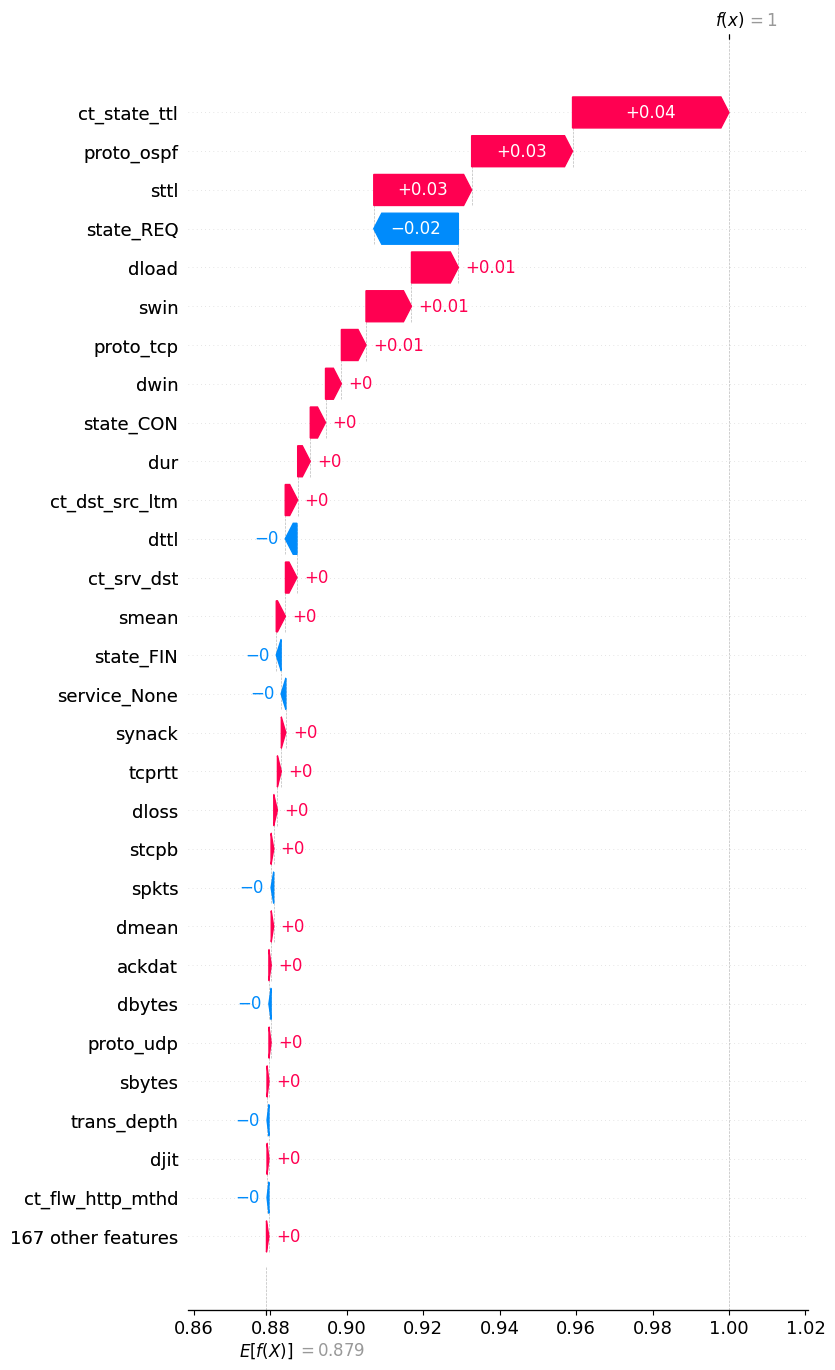

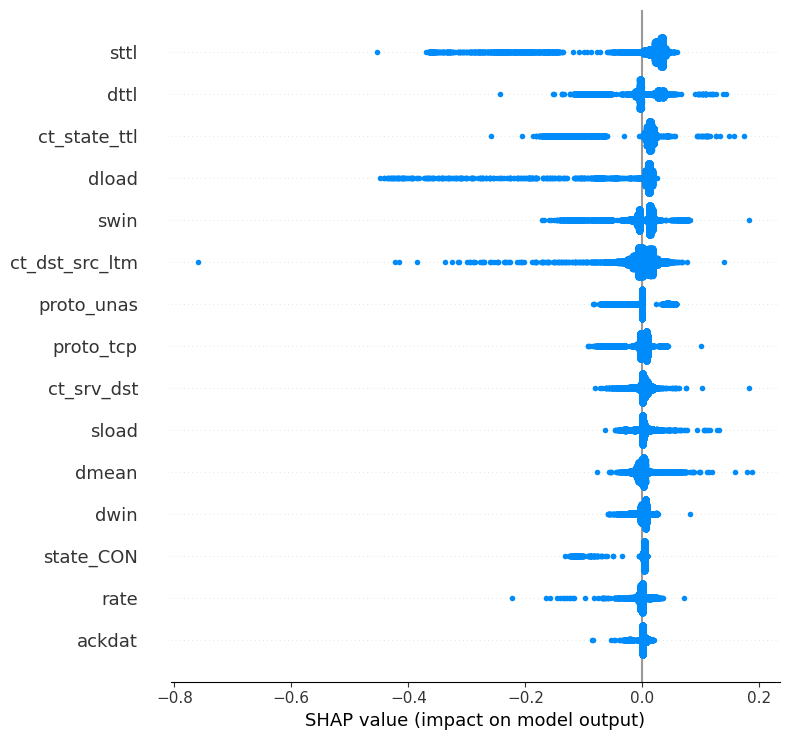

In [9]:
# display shap graph 
vals = shap_values[0]
# reshaping the values
vals = vals.reshape((vals.shape[0], vals.shape[2]))
print(len(vals[0]))
shap.waterfall_plot(shap.Explanation(values=vals[0], base_values=explainer.expected_value[0], feature_names=features), max_display = 30)
# shap.bar_plot(vals[0], feature_names=features, max_display=30)
shap.summary_plot(vals, feature_names=features, max_display=15)

In [10]:
# get top 15 features
top_15 = np.argsort(np.sum(np.abs(vals), axis=0))[-15:]
print(top_15)


[ 22   5 187  19  24   8  37 152 159  32  16   9  28   7   6]


In [11]:
df2 = df.copy()
# keep only top 20 features
df2 = df2.iloc[:,top_15]
df2['label'] = df['label']
df2

,ackdat,rate,state_CLO,dwin,dmean,sload,ct_srv_dst,proto_tcf,proto_udp,ct_dst_src_ltm,swin,dload,ct_state_ttl,dttl,sttl,label
0,0.000000,0.000462,False,2.004241,0.169264,0.000076,0.091956,False,False,0.089922,2.002085,0.003522,0.000000,2.252534,2.458823,0.0
1,0.000000,0.000489,False,2.004241,4.353636,0.000045,0.551738,False,False,0.179844,2.002085,0.208746,1.007762,2.234797,0.604948,0.0
2,1.101997,0.000088,False,2.004241,3.243577,0.000008,0.551738,False,False,0.269766,2.002085,0.025257,1.007762,2.234797,0.604948,0.0
3,0.000000,0.000085,False,2.004241,0.251928,0.000015,0.091956,False,False,0.269766,2.002085,0.001392,1.007762,2.234797,0.604948,0.0
4,1.250455,0.000208,False,2.004241,0.177137,0.000046,3.586296,False,False,3.596885,2.002085,0.001653,1.007762,2.234797,2.478337,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929995,1.103808,0.000349,False,2.004241,0.177137,0.000462,0.091956,False,False,0.089922,2.002085,0.002584,1.007762,2.234797,2.478337,1.0
929996,0.850329,0.000242,False,2.004241,0.177137,0.000082,0.183913,False,False,0.179844,2.002085,0.001919,1.007762,2.234797,2.478337,1.0
929997,0.548006,0.000371,False,2.004241,0.177137,0.000166,0.091956,False,False,0.089922,2.002085,0.002947,1.007762,2.234797,2.478337,1.0
929998,1.582174,0.000540,False,2.004241,5.182381,0.000030,0.091956,False,False,0.089922,2.002085,0.315734,1.007762,2.234797,2.478337,1.0


In [9]:
# save df2
df2.to_csv('unsw_shap_top_15.csv', index=False)

In [12]:
# train an lstm model on the data
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
X = df2.drop('label', axis=1)
Y = df2['label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)


# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start = time.time()
# train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)
end = time.time()
print("Time taken to train the model: ", end - start)

Train on 744000 samples, validate on 186000 samples
Epoch 1/10


2023-12-24 13:07:18.999157: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:4113 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/v, training/Adam/dense_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


743616/744000 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9690

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-24 13:07:56.703066: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:2945 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


744000/744000 [==============================] - 40s 54us/sample - loss: 0.1006 - acc: 0.9690 - val_loss: 0.0921 - val_acc: 0.9700
Epoch 2/10
744000/744000 [==============================] - 42s 56us/sample - loss: 0.0887 - acc: 0.9705 - val_loss: 0.0875 - val_acc: 0.9700
Epoch 3/10
744000/744000 [==============================] - 43s 58us/sample - loss: 0.0857 - acc: 0.9705 - val_loss: 0.0847 - val_acc: 0.9699
Epoch 4/10
744000/744000 [==============================] - 43s 57us/sample - loss: 0.0842 - acc: 0.9705 - val_loss: 0.0828 - val_acc: 0.9701
Epoch 5/10
744000/744000 [==============================] - 43s 58us/sample - loss: 0.0834 - acc: 0.9706 - val_loss: 0.0830 - val_acc: 0.9700
Epoch 6/10
744000/744000 [==============================] - 45s 60us/sample - loss: 0.0830 - acc: 0.9706 - val_loss: 0.0827 - val_acc: 0.9702
Epoch 7/10
744000/744000 [==============================] - 42s 57us/sample - loss: 0.0827 - acc: 0.9706 - val_loss: 0.0818 - val_acc: 0.9705
Epoch 8/10
744000

In [14]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred, digits = 4))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))
print('Time taken to predict the test data: ', end_time - start_time)

Classification Report
              precision    recall  f1-score   support

           0     0.9762    0.7240    0.8314     18731
           1     0.9700    0.9980    0.9838    167269

    accuracy                         0.9704    186000
   macro avg     0.9731    0.8610    0.9076    186000
weighted avg     0.9706    0.9704    0.9684    186000

Accuracy:
0.9704247311827957
Time taken to predict the test data:  2.1820321083068848
